In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib.pyplot import figure
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# Loading datasets from OVD web and ETL process

In [2]:
df_17 = pd.read_csv('http://datos.csjn.gov.ar/dataset/9b8126f8-c21b-4aca-8d03-88a52c4fe203/resource/3d9641ea-5ef5-4d21-92cd-1c68585f5d0d/download/20190613--ovd---datos-abiertos--2017.csv',sep = ";",encoding='latin-1')
df_18 = pd.read_csv('http://datos.csjn.gov.ar/dataset/9b8126f8-c21b-4aca-8d03-88a52c4fe203/resource/b0c8ce96-04be-42b9-abd1-e3ebb5a56b4d/download/ovddatosabiertos2018-1.csv',sep = ";",encoding='latin-1')
df_19 = pd.read_csv('http://datos.csjn.gov.ar/dataset/9b8126f8-c21b-4aca-8d03-88a52c4fe203/resource/7af36b1e-32c5-48f4-b3ac-ea74b2a909e0/download/ovd--base-datos-abiertos--ano-2019-.csv',sep = ",",encoding='latin-1')
df_20 = pd.read_csv('http://datos.csjn.gov.ar/dataset/9b8126f8-c21b-4aca-8d03-88a52c4fe203/resource/5043c468-d5bc-4f88-ac8c-bd4921e60ead/download/ovd---ddaa-ovd-2020.csv',sep = ";",encoding='latin-1')

Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
df0 = df_17.copy()
df1 = df_18.copy()
df2 = df_19.copy()
df3 = df_20.copy()

In [4]:
# Insert empty columns to equal number of columns
df0.insert(7, 'GENERO', np.nan)
df0.insert(19, 'DISCAPACIDAD', np.nan)
df0.insert(31, 'LESIONES', np.nan)
df0 = df0.drop(['PCBOTONANTIP'], axis=1)
df1.insert(7, 'GENERO', np.nan)
df1.insert(19, 'DISCAPACIDAD', np.nan)
df1.insert(31, 'LESIONES', np.nan)
df2.insert(7, 'GENERO', np.nan)
df2.insert(19, 'DISCAPACIDAD', np.nan)
df2.insert(31, 'LESIONES', np.nan)
df2.insert(47, 'ROVD', np.nan)
df2.insert(48, 'DPMENEINCAP', np.nan)

# Check equal number of columns (49)
len(df0.columns) == len(df1.columns) == len(df2.columns) == len(df3.columns) 

True

In [5]:
# Rename columns that have different names
df0 = df0.rename(columns={'SEXO_GENERO': 'SEXO','NIVEL_INSTRU': 'NIVEL_INSTRUCCION','CONDICIÓN_LABORAL': 'CONDICION_ACTIVIDAD',
                 'EVA_RIESGO': 'EVALUACION_RIESGO','DENUNCIADA_SEXO_GENERO': 'DENUNCIADA_SEXO'})
df1 = df1.rename(columns={'SEXO_GENERO': 'SEXO','NIVEL_INSTRU': 'NIVEL_INSTRUCCION','CONDICIÓN_LABORAL': 'CONDICION_ACTIVIDAD',
                 'EVA_RIESGO': 'EVALUACION_RIESGO','DENUNCIADA_SEXO_GENERO': 'DENUNCIADA_SEXO'})
df2 = df2.rename(columns={'CONDICIÓN_LABORAL': 'CONDICION_ACTIVIDAD'})
df3 = df3.rename(columns={'CDNNYA':'CONDNNYA','DENUNCIADA_COND_ACT': 'DENUNCIADA_COND_LAB',
                 'Unnamed: 47':'ROVD','Unnamed: 48':'DPMENEINCAP'})

df0["SEXO"].replace(to_replace = ['MUJER','VARON'], value = ['FEMENINO','MASCULINO'], inplace=True)
df1["SEXO"].replace(to_replace = ['MUJER','VARON'], value = ['FEMENINO','MASCULINO'], inplace=True)
df0["AÑO"].replace(to_replace = '2,017', value = '2017', inplace=True)
df1["AÑO"].replace(to_replace = 2.018, value = '2018', inplace=True)
df2["AÑO"].replace(to_replace = 2.019, value = '2019', inplace=True)
df3["AÑO"].replace(to_replace = '2,020', value = '2020', inplace=True)

In [6]:
# Concat dataframes
df = pd.concat([df0,df1, df2, df3])

df["EDAD"] = pd.to_numeric(df["EDAD"],errors='coerce',downcast='integer')
df["NIVEL_INSTRUCCION"].replace(to_replace = 'SIN INSTRUCCIÓN', value = 'SIN INSTRUCCION', inplace=True)
df["CONDICION_ACTIVIDAD"].replace(to_replace = 'TRABAJA SIN REMUNERACION - AMA DE CASA-', value = 'TRABAJA SIN REMUNERACION / AMA DE CASA', inplace=True)
df["DENUNCIADA_COND_LAB"].replace(to_replace = 'TRABAJA SIN REMUNERACION - AMA DE CASA-', value = 'TRABAJA SIN REMUNERACIÓN-AMA DE CASA', inplace=True)
df["RELACION_AFECTADA_DENUNCIADA"].replace(to_replace = ['OTROS','OTRO ','OTROS '], value = 'OTRO', inplace=True)
df.replace(to_replace = 'S/D', value = 'NULL', inplace=True)
df = df[df['EVALUACION_RIESGO'].notna()]

# Variable to predict eval highest risk = 1
df['RIESGO_ALTISIMO'] = np.where(df['EVALUACION_RIESGO']=='ALTISIMO',1,0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55838 entries, 0 to 9973
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID_DATOS_ABIERTOS_LEGAJO       55838 non-null  object 
 1   ID_DATOS_ABIERTOS_PERSONA      55838 non-null  object 
 2   AÑO                            55838 non-null  object 
 3   MES                            55838 non-null  object 
 4   INGRESO                        55838 non-null  object 
 5   LEG_TERCERA                    55838 non-null  object 
 6   SEXO                           55838 non-null  object 
 7   GENERO                         9426 non-null   object 
 8   GRUPO_EDAD                     55838 non-null  object 
 9   EDAD                           55698 non-null  float64
 10  NACIONALIDAD                   55830 non-null  object 
 11  DOMICILIO_PROVINCIA            53975 non-null  object 
 12  BARRIO                         50669 non-null  

In [7]:
# Absolute frequencies of all variables
df_null = df.fillna('NULL')
cat_cols = df_null.select_dtypes(include=object).columns.tolist()
(pd.DataFrame(
    df_null[cat_cols]
    .melt(var_name='column', value_name='value')
    .value_counts())
.rename(columns={0: 'counts'})
.sort_values(by=['column', 'counts']))
#.to_csv('frec_abs.csv')

counts
column     value        
ASJURIDICO NO       6136
           SI      49702
AÑO        2020     9973
           2017    14048
           2018    15368
...                  ...
V_SEX      NO      50348
V_SIMB     NO      25051
           SI      30787
V_SOC      SI       8473
           NO      47365

[98725 rows x 1 columns]

In [8]:
# Matching features ​​and imputing missing values

df_processed = df_null
df_processed['NIVEL_INSTRUCCION2'] = df_processed['NIVEL_INSTRUCCION']
df_processed.loc[(df_processed['NIVEL_INSTRUCCION'] == 'NULL') & (df_processed['GRUPO_EDAD'] == 'NIÑAS/OS ( 0-5 AÑOS)'), 'NIVEL_INSTRUCCION2'] = 'SIN ESCOLARIZAR'  
df_processed["NIVEL_INSTRUCCION2"].replace(to_replace = 'SIN INSTRUCCION', value = 'SIN ESCOLARIZAR', inplace=True)

df_processed['CONDICION_ACTIVIDAD2'] = df_processed['CONDICION_ACTIVIDAD']
df_processed.loc[(df_processed['CONDICION_ACTIVIDAD'] == 'NULL') & ((df_processed['GRUPO_EDAD'] != 'NIÑAS/OS ( 0-5 AÑOS)')|(df_processed['GRUPO_EDAD'] != 'NIÑAS/OS ( 6-10 AÑOS)')), 'CONDICION_ACTIVIDAD2'] = 'OTRA SITUACION'  
df_processed.loc[(df_processed['CONDICION_ACTIVIDAD'] == 'NULL') & ((df_processed['GRUPO_EDAD'] == 'NIÑAS/OS ( 0-5 AÑOS)')|(df_processed['GRUPO_EDAD'] == 'NIÑAS/OS ( 6-10 AÑOS)')), 'CONDICION_ACTIVIDAD2'] = 'INFANCIA'  

df_processed['NACIONALIDAD2'] = df_processed['NACIONALIDAD']
df_processed.loc[(df_processed['NACIONALIDAD'] != 'ARGENTINA')&(df_processed['NACIONALIDAD'] != 'BOLIVIA')&(df_processed['NACIONALIDAD'] != 'PARAGUAY')&(df_processed['NACIONALIDAD'] != 'PERU')&(df_processed['NACIONALIDAD'] != 'VENEZUELA'), 'NACIONALIDAD2'] = 'OTRA'  

df_processed['COMUNA2'] = df_processed['COMUNA']
df_processed.loc[(df_processed["DOMICILIO_PROVINCIA"] == 'CIUDAD DE BS. AS.')&(df_processed["COMUNA"] == 'NULL'),'COMUNA2'] = 'OTRA'
df_processed.loc[(df_processed["DOMICILIO_PROVINCIA"] == 'NULL')&(df_processed["COMUNA"] == 'NULL'),'COMUNA2'] = 'SIN DATOS'
df_processed["COMUNA2"].replace(to_replace = 'NULL', value = 'NO CABA', inplace=True)

df_processed["COHABITAN"].replace(to_replace = 'NULL', value = 'SIN DATOS', inplace=True)
df_processed["DENUNCIADA_EDAD"].replace(to_replace = 'NULL', value = 'SIN DATOS', inplace=True)
df_processed["DENUNCIADA_NIVEL_INSTRU"].replace(to_replace = 'SECUNADRIO INCOMPLETO', value = 'SECUNDARIO INCOMPLETO', inplace=True)
df_processed["DENUNCIADA_NIVEL_INSTRU"].replace(to_replace = 'SIN INSTRUCCION', value = 'SIN ESCOLARIZAR', inplace=True)
df_processed["DENUNCIADA_NIVEL_INSTRU"].replace(to_replace = 'NULL', value = 'SIN DATOS', inplace=True)
df_processed["DENUNCIADA_COND_LAB"].replace(to_replace = 'NULL', value = 'SIN DATOS', inplace=True)
df_processed["DENUNCIADA_COND_LAB"].replace(to_replace = 'JUBILADA/PENSIONADA', value = 'JUBILADA / PENSIONADA', inplace=True)
df_processed["DENUNCIADA_SEXO"].replace(to_replace = 'NULL', value = 'SIN DATOS', inplace=True)
df_processed["DOMICILIO_PROVINCIA"].replace(to_replace = 'NULL', value = 'SIN DATOS', inplace=True)

# imputo los valores faltates de edad con el promeido de edad
df_processed['EDAD'] = df['EDAD'].fillna((df['EDAD'].mean()))

In [9]:
df_processed['COMUNA_AGRUP'] = df_processed['COMUNA'].map({'COMUNA 01': 'S',
                                                                'COMUNA 02': 'N',
                                                                'COMUNA 03': 'C',
                                                                'COMUNA 04': 'S',
                                                                'COMUNA 05': 'C',
                                                                'COMUNA 06': 'C',
                                                                'COMUNA 07': 'S',
                                                                'COMUNA 08': 'S',
                                                                'COMUNA 09': 'C',
                                                                'COMUNA 10': 'C',
                                                                'COMUNA 11': 'C',
                                                                'COMUNA 12': 'N',
                                                                'COMUNA 13': 'N',
                                                                'COMUNA 14': 'N',
                                                                'COMUNA 15': 'C',
                                                                'NULL': 'O'
                                                                })
df_processed['RIESGO_ALTO'] = df_processed['RIESGO_ALTISIMO']
df_processed.loc[(df_processed["EVALUACION_RIESGO"] == 'ALTO'),'RIESGO_ALTO'] = 1

# Data analysis and visualization

In [10]:
def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 12)
    plt.show()

def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
    plt.show()

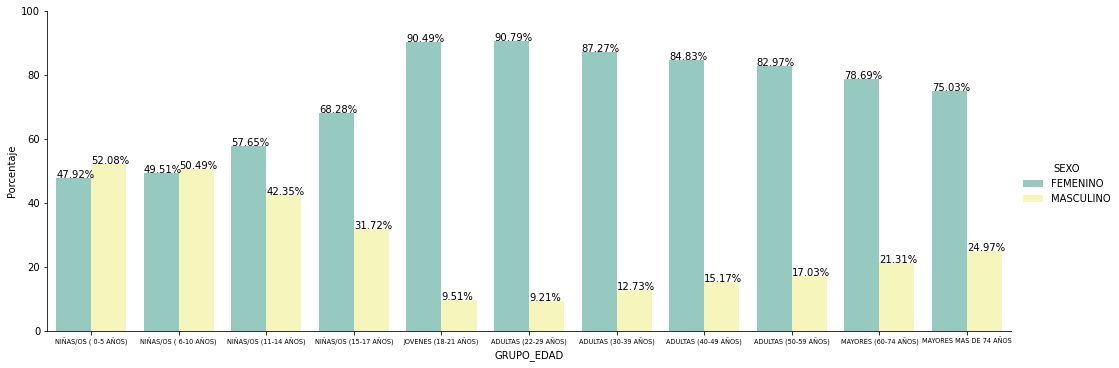

In [11]:
import textwrap
x,y = 'GRUPO_EDAD', 'SEXO'

df_sns = df.groupby(x)[y].value_counts(normalize=True)
df_sns = df_sns.mul(100)
df_sns = df_sns.rename('Porcentaje').reset_index()

g = sns.catplot(x=x,
                y='Porcentaje',
                hue=y,
                kind='bar',
                data=df_sns, 
                #hue_order=[],
                order=['NIÑAS/OS ( 0-5 AÑOS)',
              'NIÑAS/OS ( 6-10 AÑOS)',
              'NIÑAS/OS (11-14 AÑOS)',
              'NIÑAS/OS (15-17 AÑOS)',
              'JOVENES (18-21 AÑOS)',
              'ADULTAS (22-29 AÑOS)',
              'ADULTAS (30-39 AÑOS)',
              'ADULTAS (40-49 AÑOS)',
              'ADULTAS (50-59 AÑOS)',
              'MAYORES (60-74 AÑOS)',
              'MAYORES MAS DE 74 AÑOS'],
                palette='Set3',
                height=5, aspect=2.8)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
    plt.xticks(size=6.5)


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


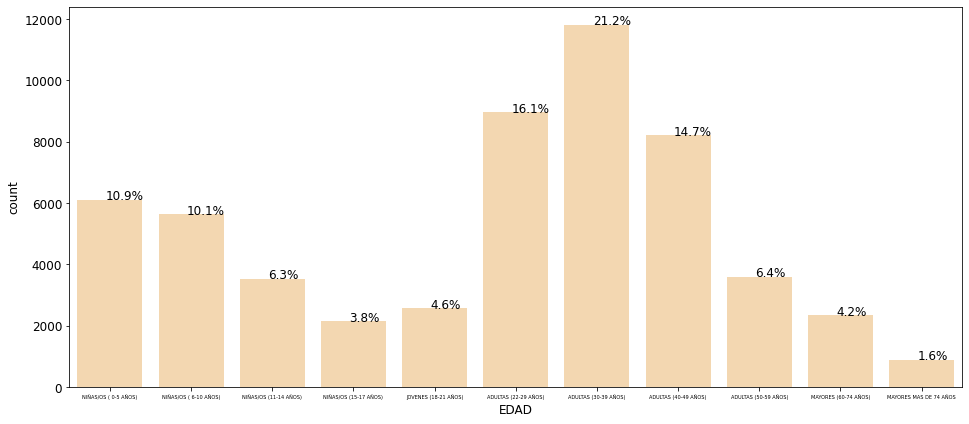

In [12]:
plt.figure(figsize=(16,7))
color = sns.color_palette('Pastel1_r',1)
ax = sns.countplot('GRUPO_EDAD',
                data=df_processed, 
                order=['NIÑAS/OS ( 0-5 AÑOS)',
              'NIÑAS/OS ( 6-10 AÑOS)',
              'NIÑAS/OS (11-14 AÑOS)',
              'NIÑAS/OS (15-17 AÑOS)',
              'JOVENES (18-21 AÑOS)',
              'ADULTAS (22-29 AÑOS)',
              'ADULTAS (30-39 AÑOS)',
              'ADULTAS (40-49 AÑOS)',
              'ADULTAS (50-59 AÑOS)',
              'MAYORES (60-74 AÑOS)',
              'MAYORES MAS DE 74 AÑOS'],
                palette=color)
plt.xticks(size=5)
plt.xlabel('EDAD',size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)
without_hue(ax,df_processed.GRUPO_EDAD)

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


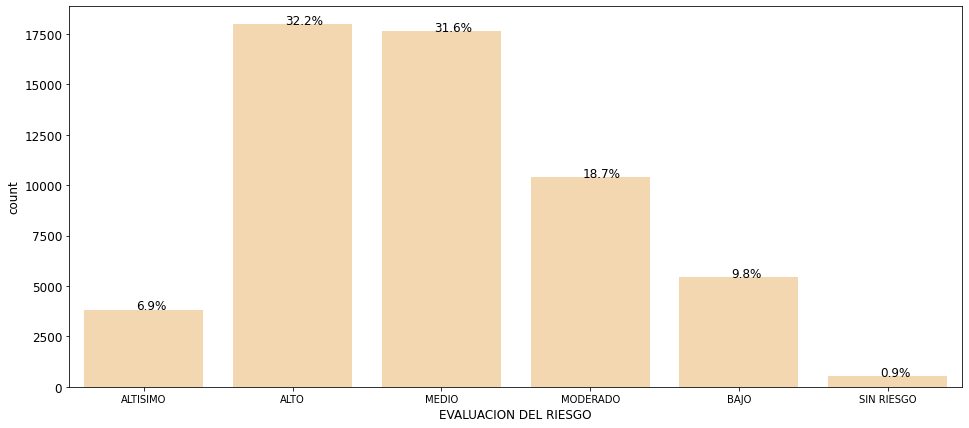

In [13]:
plt.figure(figsize=(16,7))
color = sns.color_palette('Pastel1_r',1)
ax = sns.countplot('EVALUACION_RIESGO',
                data=df_processed, 
                order=['ALTISIMO','ALTO','MEDIO','MODERADO','BAJO','SIN RIESGO'],
                palette=color)
plt.xticks(size=10)
plt.xlabel('EVALUACION DEL RIESGO',size=12)
plt.yticks(size=12)
plt.ylabel('count',size=12)
without_hue(ax,df_processed.GRUPO_EDAD)

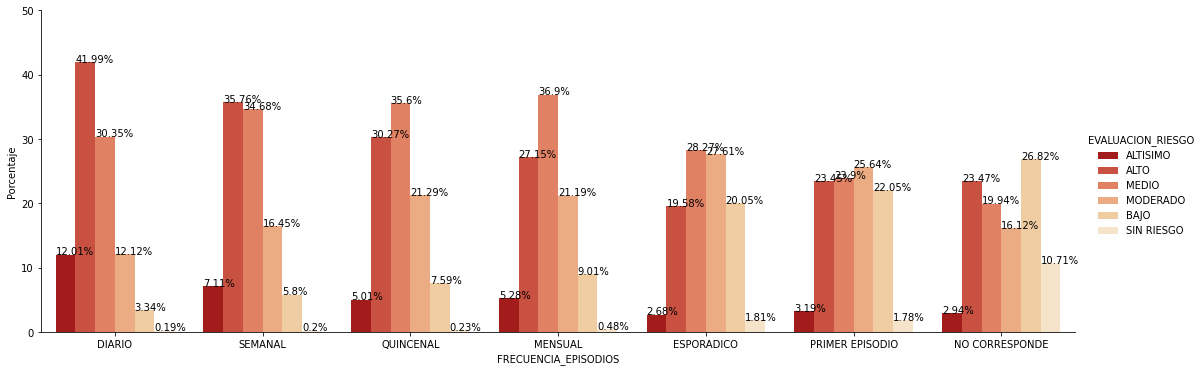

In [14]:
# FREQUENCY OF EPISODES ACCORDING TO RISK ASSESSMENT -> the higher the frequency, the higher the risk

x,y = 'FRECUENCIA_EPISODIOS', 'EVALUACION_RIESGO'

df_sns = df.groupby(x)[y].value_counts(normalize=True)
df_sns = df_sns.mul(100)
df_sns = df_sns.rename('Porcentaje').reset_index()

g = sns.catplot(x=x,
                y='Porcentaje',
                hue=y,
                kind='bar',
                data=df_sns, 
                hue_order=['ALTISIMO','ALTO','MEDIO','MODERADO','BAJO','SIN RIESGO'],
                order= ['DIARIO','SEMANAL','QUINCENAL','MENSUAL','ESPORADICO','PRIMER EPISODIO','NO CORRESPONDE'],
                height=5, aspect=3,palette='OrRd_r')
g.ax.set_ylim(0,50)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

# Converting categorical features to numeric and creating new features

In [15]:
# I define the categorical, ordinal, numeric variables
cat_columns = ['AÑO',
               'INGRESO',
               'LEG_TERCERA','SEXO','NACIONALIDAD2',
               #'DOMICILIO_PROVINCIA',
               'COMUNA_AGRUP',
               'CONDICION_ACTIVIDAD2','RELACION_AFECTADA_DENUNCIADA',
               'COHABITAN','V_FISICA','V_PSIC','V_ECON','V_SEX','V_SOC','V_AMB','V_SIMB','DENUNCIADA_SEXO','DENUNCIADA_COND_LAB',
               #'JNCIVIL','JPENAL','ASJURIDICO','SISTSALUD','DGM','CONDNNYA','INSTNOJUDICIAL','JUSPROV','PROTEGER','SZYPDN','DGMREFUGIO',
               #'LESIONES'
               ]
ord_columns = ['GRUPO_EDAD__ORD','NIVEL_INSTRUCCION__ORD','FRECUENCIA_EPISODIOS__ORD','DENUNCIADA_EDAD__ORD','DENUNCIADA_NIVEL_INSTRU__ORD']

# This features are left out because they are completed after the risk assessment
# JNCIVIL,JPENAL,ASJURIDICO,SISTSALUD,DGM,CONDNNYA,INSTNOJUDICIAL,JUSPROV,PROTEGER,SZYPDN,DGMREFUGIO
#'INGRESO',

In [16]:
df_processed = pd.get_dummies(df_processed, prefix_sep="__",
                              columns=cat_columns)
df_processed

,ID_DATOS_ABIERTOS_LEGAJO,ID_DATOS_ABIERTOS_PERSONA,MES,GENERO,GRUPO_EDAD,EDAD,NACIONALIDAD,DOMICILIO_PROVINCIA,BARRIO,COMUNA,...,DENUNCIADA_SEXO__MUJER,DENUNCIADA_SEXO__SIN DATOS,DENUNCIADA_SEXO__VARON,DENUNCIADA_COND_LAB__DESOCUPADA,DENUNCIADA_COND_LAB__INFANCIA,DENUNCIADA_COND_LAB__JUBILADA / PENSIONADA,DENUNCIADA_COND_LAB__OCUPADA REMUNERADA,DENUNCIADA_COND_LAB__OTRA SITUACION,DENUNCIADA_COND_LAB__SIN DATOS,DENUNCIADA_COND_LAB__TRABAJA SIN REMUNERACIÓN-AMA DE CASA
0,AABVJuAAmAACMXBAAs,AAASVGAAZAADzc7AAJ,ENERO,NULL,ADULTAS (40-49 AÑOS),46.0,REPUBLICA DOMINICANA,SIN DATOS,NULL,NULL,...,0,0,1,0,0,1,0,0,0,0
1,AABVJuAAmAACMXBAAt,AAASVGAAZAADzcrAAA,ENERO,NULL,ADULTAS (22-29 AÑOS),25.0,ARGENTINA,CIUDAD DE BS. AS.,CABALLITO,COMUNA 06,...,1,0,0,0,0,0,1,0,0,0
2,AABVJuAAmAACMXBAAu,AAASVGAAZAADzdLAAI,ENERO,NULL,ADULTAS (30-39 AÑOS),37.0,ARGENTINA,CIUDAD DE BS. AS.,BELGRANO,COMUNA 13,...,0,0,1,0,0,0,1,0,0,0
3,AABVJuAAmAACMXBAAv,AAASVGAAZAADzRQAAB,ENERO,NULL,ADULTAS (30-39 AÑOS),34.0,ESTADOS UNIDOS,CIUDAD DE BS. AS.,SAN NICOLAS,COMUNA 01,...,0,0,1,1,0,0,0,0,0,0
4,AABVJuAAmAACMXBAAv,AAASVGAAZAADzVJAAE,ENERO,NULL,NIÑAS/OS ( 0-5 AÑOS),2.0,ARGENTINA,CIUDAD DE BS. AS.,SAN NICOLAS,COMUNA 01,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9969,AABHbUAAFAAOAAfAAi,AABHZdAADAAKBq1AAA,DICIEMBRE,MUJER CIS,NIÑAS/OS ( 6-10 AÑOS),8.0,ARGENTINA,CIUDAD DE BS. AS.,FLORES,COMUNA 07,...,0,0,1,1,0,0,0,0,0,0
9970,AABHbUAAFAAOAAfAAi,AABHZdAADAAKBq1AAB,DICIEMBRE,VARON CIS,NIÑAS/OS ( 0-5 AÑOS),2.0,ARGENTINA,CIUDAD DE BS. AS.,FLORES,COMUNA 07,...,0,0,1,1,0,0,0,0,0,0
9971,AABHbUAAFAAOAARAAv,AABHZdAADAAKBqnAAF,DICIEMBRE,MUJER CIS,ADULTAS (40-49 AÑOS),45.0,PERU,CIUDAD DE BS. AS.,RETIRO,COMUNA 01,...,1,0,0,0,0,0,1,0,0,0
9972,AABHbUAAFAAOABKAA0,AABHZdAADAAKBdyAAG,DICIEMBRE,NULL,NIÑAS/OS ( 0-5 AÑOS),4.0,ARGENTINA,CIUDAD DE BS. AS.,NUEVA POMPEYA,COMUNA 04,...,0,0,1,0,0,0,0,0,1,0


In [17]:
# Converting to dummies
cat_dummies = [col for col in df_processed 
               if "__" in col 
               and col.split("__")[0] in cat_columns]
processed_columns = list(df_processed.columns[:])
cat_dummies

['AÑO__2017',
 'AÑO__2018',
 'AÑO__2019',
 'AÑO__2020',
 'INGRESO__ 137 BRIGADA',
 'INGRESO__ 137 BRIGADA EN OVD',
 'INGRESO__ 137 LINEA',
 'INGRESO__ABOGADA/O',
 'INGRESO__ATENCION ANTERIOR EN OVD',
 'INGRESO__CENTRO ASISTENCIAL',
 'INGRESO__CGP',
 'INGRESO__COMISARIA',
 'INGRESO__COMISARÍA DE LA MUJER',
 'INGRESO__CONSEJO DE DERECHOS DE  NIÑAS/OS Y ADOLESCENTES',
 'INGRESO__CONSEJO DE DERECHOS DE NIÑAS/OS Y ADOLESCENTES',
 'INGRESO__CONSULTA ANTERIOR EN OVD',
 'INGRESO__DEFENSORIA DE MENORES E INCAPACES',
 'INGRESO__DEFENSORIA DEL PUEBLO',
 'INGRESO__DEFENSORIA EN OVD',
 'INGRESO__DEFENSORIA GENERAL DE LA NACION',
 'INGRESO__DENUNCIA ANTERIOR',
 'INGRESO__DIRECCION GENERAL DE LA MUJER',
 'INGRESO__DIRECTA',
 'INGRESO__FUERZAS DE SEGURIDAD',
 'INGRESO__GCBA',
 'INGRESO__GENDARMERIA',
 'INGRESO__INTERNET',
 'INGRESO__JUSTICIA',
 'INGRESO__JUSTICIA CIVIL',
 'INGRESO__JUSTICIA PENAL CONTRAVENCIONAL Y DE FALTAS',
 'INGRESO__JUSTICIA PENAL CORRECCIONAL',
 'INGRESO__JUSTICIA PENAL DE INSTRU

In [18]:
cat_columns2 = [   'AÑO__2017',
 'AÑO__2018',
 'AÑO__2019',
 'AÑO__2020',
 'INGRESO__ 137 BRIGADA',
 'INGRESO__ 137 BRIGADA EN OVD',
 'INGRESO__ 137 LINEA',
 'INGRESO__ABOGADA/O',
 'INGRESO__ATENCION ANTERIOR EN OVD',
 'INGRESO__CENTRO ASISTENCIAL',
 'INGRESO__CGP',
 'INGRESO__COMISARIA',
 'INGRESO__COMISARÍA DE LA MUJER',
 'INGRESO__CONSEJO DE DERECHOS DE  NIÑAS/OS Y ADOLESCENTES',
 'INGRESO__CONSEJO DE DERECHOS DE NIÑAS/OS Y ADOLESCENTES',
 'INGRESO__CONSULTA ANTERIOR EN OVD',
 'INGRESO__DEFENSORIA DE MENORES E INCAPACES',
 'INGRESO__DEFENSORIA DEL PUEBLO',
 'INGRESO__DEFENSORIA EN OVD',
 'INGRESO__DEFENSORIA GENERAL DE LA NACION',
 'INGRESO__DENUNCIA ANTERIOR',
 'INGRESO__DIRECCION GENERAL DE LA MUJER',
 'INGRESO__DIRECTA',
 'INGRESO__FUERZAS DE SEGURIDAD',
 'INGRESO__GCBA',
 'INGRESO__GENDARMERIA',
 'INGRESO__INTERNET',
 'INGRESO__JUSTICIA',
 'INGRESO__JUSTICIA CIVIL',
 'INGRESO__JUSTICIA PENAL CONTRAVENCIONAL Y DE FALTAS',
 'INGRESO__JUSTICIA PENAL CORRECCIONAL',
 'INGRESO__JUSTICIA PENAL DE INSTRUCCION',
 'INGRESO__JUSTICIA PENAL DE MENORES',
 'INGRESO__LINEA 144',
 'INGRESO__MEDIOS DE COMUNICACIÓN / NOTICIA PERIODISTICA',
 'INGRESO__MINISTERIO DE JUSTICIA - CAJ',
 'INGRESO__MINISTERIO PUBLICO FISCAL DE LA CABA',
 'INGRESO__MINISTERIO PUBLICO FISCAL DE LA NACION',
 'INGRESO__OFICINA DE ASISTENCIA A LA VICTIMA DE LA CABA',
 'INGRESO__ONG',
 'INGRESO__OTROS',
 'INGRESO__PATROCINIO JURIDICO GRATUITO',
 'INGRESO__POLICIA DE LA CIUDAD',
 'INGRESO__POLICIA METROPOLITANA',
 'INGRESO__PREFECTURA',
 'INGRESO__PROFESIONAL DE LA ABOGACIA',
 'INGRESO__PROGRAMA PROTEGER',
 'INGRESO__PROGRAMA VICTIMAS CONTRA LAS VIOLENCIAS',
 'INGRESO__REFERENCIAS DE OTRAS PERSONAS',
 'INGRESO__SISTEMA DE SALUD',
 'INGRESO__SISTEMA EDUCATIVO',  
 'LEG_TERCERA__SI',
 'SEXO__FEMENINO',
 'NACIONALIDAD2__ARGENTINA',
 'COMUNA_AGRUP__C',
 'COMUNA_AGRUP__N',
 'COMUNA_AGRUP__O',
 'COMUNA_AGRUP__S',
 'CONDICION_ACTIVIDAD2__DESOCUPADA',
 'CONDICION_ACTIVIDAD2__INFANCIA',
 'CONDICION_ACTIVIDAD2__JUBILADA / PENSIONADA',
 'CONDICION_ACTIVIDAD2__OCUPADA REMUNERADA',
 'CONDICION_ACTIVIDAD2__OTRA SITUACION',
 'CONDICION_ACTIVIDAD2__TRABAJA SIN REMUNERACION / AMA DE CASA',
 'RELACION_AFECTADA_DENUNCIADA__AMISTAD',
 'RELACION_AFECTADA_DENUNCIADA__CONVIVIENTES',
 'RELACION_AFECTADA_DENUNCIADA__CÓNYUGES',
 'RELACION_AFECTADA_DENUNCIADA__EX PAREJAS',
 'RELACION_AFECTADA_DENUNCIADA__FILIAL',
 'RELACION_AFECTADA_DENUNCIADA__FRATERNAL',
 'RELACION_AFECTADA_DENUNCIADA__LABORAL',
 'RELACION_AFECTADA_DENUNCIADA__NOVIOS',
 'RELACION_AFECTADA_DENUNCIADA__OTRO',
 'RELACION_AFECTADA_DENUNCIADA__OTRO FAMILIAR HASTA 4º GRADO DE PARENTESCO',
 'COHABITAN__SI',
 'V_FISICA__SI',
 'V_PSIC__SI',
 'V_ECON__SI',
 'V_SEX__SI',
 'V_SOC__SI',
 'V_AMB__SI',
 'V_SIMB__SI',
 'DENUNCIADA_SEXO__VARON',
 'DENUNCIADA_COND_LAB__DESOCUPADA',
 'DENUNCIADA_COND_LAB__INFANCIA',
 'DENUNCIADA_COND_LAB__JUBILADA / PENSIONADA',
 'DENUNCIADA_COND_LAB__OCUPADA REMUNERADA',
 'DENUNCIADA_COND_LAB__OTRA SITUACION',
 'DENUNCIADA_COND_LAB__TRABAJA SIN REMUNERACIÓN-AMA DE CASA',
 #'JNCIVIL__SI',
 #'JPENAL__SI',
 #'ASJURIDICO__SI',
 #'SISTSALUD__SI',
 #'DGM__SI',
 #'CONDNNYA__SI',
 #'INSTNOJUDICIAL__SI',
 #'JUSPROV__SI',
 #'PROTEGER__SI',
 #'SZYPDN__SI',
 #'DGMREFUGIO__SI',
 #'LESIONES__SI'
 ]

In [19]:
# 'GRUPO_EDAD','NIVEL_INSTRUCCION','FRECUENCIA_EPISODIOS','DENUNCIADA_EDAD','DENUNCIADA_NIVEL_INSTRU'
df_processed['GRUPO_EDAD__ORD'] = df_processed['GRUPO_EDAD'].map({'NIÑAS/OS ( 0-5 AÑOS)': 1,
                                                                'NIÑAS/OS ( 6-10 AÑOS)': 2,
                                                                'NIÑAS/OS (11-14 AÑOS)': 3,
                                                                'NIÑAS/OS (15-17 AÑOS)': 4,
                                                                'JOVENES (18-21 AÑOS)': 5,
                                                                'ADULTAS (22-29 AÑOS)': 6,
                                                                'ADULTAS (30-39 AÑOS)': 7,
                                                                'ADULTAS (40-49 AÑOS)': 8,
                                                                'ADULTAS (50-59 AÑOS)': 9,
                                                                'MAYORES (60-74 AÑOS)': 10,
                                                                'MAYORES MAS DE 74 AÑOS': 11
                                                                })
df_processed['DENUNCIADA_EDAD__ORD'] = df_processed['DENUNCIADA_EDAD'].map({'NIÑAS/OS ( 0-5 AÑOS)': 1,
                                                                'NIÑAS/OS ( 6-10 AÑOS)': 2,
                                                                'NIÑAS/OS (11-14 AÑOS)': 3,
                                                                'NIÑAS/OS (15-17 AÑOS)': 4,
                                                                'JOVENES (18-21 AÑOS)': 5,
                                                                'ADULTAS (22-29 AÑOS)': 6,
                                                                'ADULTAS (30-39 AÑOS)': 7,
                                                                'ADULTAS (40-49 AÑOS)': 8,
                                                                'ADULTAS (50-59 AÑOS)': 9,
                                                                'MAYORES (60-74 AÑOS)': 10,
                                                                'MAYORES MAS DE 74 AÑOS': 11,
                                                                'SIN DATOS': 7 #LA MODA
                                                                })

In [20]:
df_processed['NIVEL_INSTRUCCION__ORD'] = df_processed['NIVEL_INSTRUCCION2'].map({'SIN ESCOLARIZAR': 0,
                                                                                'NIVEL INICIAL -JARDIN-': 1,
                                                                                'PRIMARIO INCOMPLETO': 2,
                                                                                'PRIMARIO COMPLETO': 3,
                                                                                'SECUNDARIO INCOMPLETO': 4,
                                                                                'SECUNDARIO COMPLETO': 5,
                                                                                'TERCIARIO INCOMPLETO': 6,
                                                                                'TERCIARIO COMPLETO': 7,
                                                                                'UNIVERSITARIO INCOMPLETO': 8,
                                                                                'UNIVERSITARIO COMPLETO': 9,
                                                                                'SIN DATOS': 4, # LA MODA
                                                                                'NULL':4 # LA MODA
                                                                                })
df_processed['DENUNCIADA_NIVEL_INSTRU__ORD'] = df_processed['DENUNCIADA_NIVEL_INSTRU'].map({'SIN ESCOLARIZAR': 0,
                                                                                'NIVEL INICIAL -JARDIN-': 1,
                                                                                'PRIMARIO INCOMPLETO': 2,
                                                                                'PRIMARIO COMPLETO': 3,
                                                                                'SECUNDARIO INCOMPLETO': 4,
                                                                                'SECUNDARIO COMPLETO': 5,
                                                                                'TERCIARIO INCOMPLETO': 6,
                                                                                'TERCIARIO COMPLETO': 7,
                                                                                'UNIVERSITARIO INCOMPLETO': 8,
                                                                                'UNIVERSITARIO COMPLETO': 9,
                                                                                'SIN DATOS': 4,
                                                                                'NULL':4
                                                                                })

In [21]:
# 'GRUPO_EDAD','NIVEL_INSTRUCCION','FRECUENCIA_EPISODIOS','DENUNCIADA_EDAD','DENUNCIADA_NIVEL_INSTRU'
df_processed['FRECUENCIA_EPISODIOS__ORD'] = df_processed['FRECUENCIA_EPISODIOS'].map({'DIARIO': 30,
                                                                'SEMANAL': 4,
                                                                'QUINCENAL': 2,
                                                                'MENSUAL': 1,
                                                                'ESPORADICO': 0.5,
                                                                'PRIMER EPISODIO': 1,
                                                                'NO CORRESPONDE': 0
                                                                })    

In [22]:
# NEW FEATURES
df_processed['SUM_VIOLENCIAS']=df_processed['V_FISICA__SI']+df_processed['V_PSIC__SI']+df_processed['V_ECON__SI']+df_processed['V_SEX__SI']+df_processed['V_SOC__SI']+df_processed['V_AMB__SI']+df_processed['V_SIMB__SI']
df_processed['VIOLENCIAS_X_FREC']=(df_processed['V_FISICA__SI']+df_processed['V_PSIC__SI']+df_processed['V_ECON__SI']+df_processed['V_SEX__SI']+df_processed['V_SOC__SI']+df_processed['V_AMB__SI']+df_processed['V_SIMB__SI'])*df_processed['FRECUENCIA_EPISODIOS__ORD']
cant_denuncias = df_processed.value_counts(['ID_DATOS_ABIERTOS_LEGAJO']).reset_index(name='CANT_DENUNCIAS')
df_processed = pd.merge(left=df_processed,
                        right=cant_denuncias,
                        how="left",
                        on='ID_DATOS_ABIERTOS_LEGAJO'
                        )
df_processed['DENUNCIAS_X_FREC']=df_processed['CANT_DENUNCIAS']*df_processed['FRECUENCIA_EPISODIOS__ORD']
df_processed['SUM_VIOLENCIAS_POND']=df_processed['V_FISICA__SI']*4+df_processed['V_PSIC__SI']*5+df_processed['V_ECON__SI']*2+df_processed['V_SEX__SI']*7+df_processed['V_SOC__SI']*6+df_processed['V_AMB__SI']*3+df_processed['V_SIMB__SI']*1
df_processed['SUM_VIOLENCIAS_POND_X_FRE']=(df_processed['V_FISICA__SI']*4+df_processed['V_PSIC__SI']*5+df_processed['V_ECON__SI']*2+df_processed['V_SEX__SI']*7+df_processed['V_SOC__SI']*6+df_processed['V_AMB__SI']*3+df_processed['V_SIMB__SI']*1)*df_processed['FRECUENCIA_EPISODIOS__ORD']

#df_processed

In [23]:
num_columns = ['EDAD',
               'SUM_VIOLENCIAS',
               'CANT_DENUNCIAS',
               'VIOLENCIAS_X_FREC',
               'DENUNCIAS_X_FREC',
               'SUM_VIOLENCIAS_POND',
               'SUM_VIOLENCIAS_POND_X_FRE'
               ] 

In [24]:
df_processed['SCORE_RIESGO'] = df_processed['EVALUACION_RIESGO'].map({'ALTISIMO':1,
                                                                      'ALTO':0.75,
                                                                      'MEDIO':0.5,
                                                                      'MODERADO':0.3,
                                                                      'BAJO':0.2,
                                                                      'SIN RIESGO':0
                                                                })

In [25]:
result = pd.concat([df_processed[num_columns],df_processed[ord_columns],df_processed[cat_columns2],df_processed['RIESGO_ALTISIMO'],df_processed['RIESGO_ALTO'],df_processed['SCORE_RIESGO'] ],axis=1)
result

result.corr()

,EDAD,SUM_VIOLENCIAS,CANT_DENUNCIAS,VIOLENCIAS_X_FREC,DENUNCIAS_X_FREC,SUM_VIOLENCIAS_POND,SUM_VIOLENCIAS_POND_X_FRE,GRUPO_EDAD__ORD,NIVEL_INSTRUCCION__ORD,FRECUENCIA_EPISODIOS__ORD,...,DENUNCIADA_SEXO__VARON,DENUNCIADA_COND_LAB__DESOCUPADA,DENUNCIADA_COND_LAB__INFANCIA,DENUNCIADA_COND_LAB__JUBILADA / PENSIONADA,DENUNCIADA_COND_LAB__OCUPADA REMUNERADA,DENUNCIADA_COND_LAB__OTRA SITUACION,DENUNCIADA_COND_LAB__TRABAJA SIN REMUNERACIÓN-AMA DE CASA,RIESGO_ALTISIMO,RIESGO_ALTO,SCORE_RIESGO
EDAD,1.000000,0.119206,-0.422590,0.048451,-0.183779,0.071955,0.035571,0.957079,0.541214,0.001153,...,0.006463,0.043737,-0.006753,0.153955,-0.076963,0.008860,-0.036208,-0.099829,-0.187028,-0.213409
SUM_VIOLENCIAS,0.119206,1.000000,-0.082473,0.409093,0.057608,0.929599,0.388989,0.180076,0.142906,0.139689,...,0.311040,0.023342,-0.010285,-0.017885,0.064243,0.009011,-0.117662,0.176044,0.302673,0.401067
CANT_DENUNCIAS,-0.422590,-0.082473,1.000000,0.037484,0.489281,-0.083805,0.038444,-0.484842,-0.397172,0.087400,...,-0.011284,0.003485,-0.005942,-0.050323,0.009065,0.002290,0.046268,0.167356,0.224163,0.243233
VIOLENCIAS_X_FREC,0.048451,0.409093,0.037484,1.000000,0.631842,0.390279,0.984372,0.060827,0.026175,0.879803,...,0.125714,0.059002,0.004057,0.014999,-0.017600,0.008689,-0.035452,0.171998,0.245883,0.297860
DENUNCIAS_X_FREC,-0.183779,0.057608,0.489281,0.631842,1.000000,0.051838,0.631878,-0.214598,-0.190058,0.762917,...,0.021984,0.038220,0.005836,-0.010214,-0.024006,0.013874,0.030282,0.175826,0.235620,0.270350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DENUNCIADA_COND_LAB__OTRA SITUACION,0.008860,0.009011,0.002290,0.008689,0.013874,0.007108,0.006593,0.006983,0.000624,0.008285,...,0.008967,-0.098088,-0.012917,-0.035459,-0.285963,1.000000,-0.041552,0.015877,0.026367,0.032137
DENUNCIADA_COND_LAB__TRABAJA SIN REMUNERACIÓN-AMA DE CASA,-0.036208,-0.117662,0.046268,-0.035452,0.030282,-0.084589,-0.026137,-0.052091,-0.070691,-0.004353,...,-0.393351,-0.096181,-0.012666,-0.034769,-0.280403,-0.041552,1.000000,-0.029215,-0.050419,-0.084944
RIESGO_ALTISIMO,-0.099829,0.176044,0.167356,0.171998,0.175826,0.191128,0.177714,-0.100761,-0.106254,0.122851,...,0.087999,0.057674,0.002238,-0.001437,-0.034422,0.015877,-0.029215,1.000000,0.339165,0.533428
RIESGO_ALTO,-0.187028,0.302673,0.224163,0.245883,0.235620,0.320926,0.248667,-0.195437,-0.202039,0.191379,...,0.185331,0.082493,0.014981,-0.006390,-0.043571,0.026367,-0.050419,0.339165,1.000000,0.862867


In [26]:
# LogisticRegression is used to rank violences and their weight in risk assessment

violencias =  ['V_FISICA__SI',
 'V_PSIC__SI',
 'V_ECON__SI',
 'V_SEX__SI',
 'V_SOC__SI',
 'V_AMB__SI',
 'V_SIMB__SI']
X = result[violencias] # Features
y = result['RIESGO_ALTISIMO'] # Target variable
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42) # 70% training and 30% test
logreg = LogisticRegression()
modelo=logreg.fit(X_train_v,y_train_v)
modelo.coef_
#['V_FISICA__SI' ,'V_PSIC__SI','V_ECON__SI', 1'V_SEX__SI', 3'V_SOC__SI', 2'V_AMB__SI','V_SIMB__SI']



array([[0.49815223, 0.59813184, 0.32849927, 0.93136504, 0.66385461,
        0.41378639, 0.22454816]])

In [27]:
#Datasets para pruebas con subpoblaciones
df_17_18_19 =  result.loc[(result['AÑO__2017'] == 1)|(result['AÑO__2018'] == 1)|(result['AÑO__2019'] == 1)]
infantil = result.loc[((result['GRUPO_EDAD__ORD'] == 1)|(result['GRUPO_EDAD__ORD'] == 2)|(result['GRUPO_EDAD__ORD'] == 3))&(result['RELACION_AFECTADA_DENUNCIADA__FILIAL'] == 1)]
mujeres = result.loc[(result['GRUPO_EDAD__ORD'] != 1)&(result['GRUPO_EDAD__ORD'] != 2)&(result['GRUPO_EDAD__ORD'] != 3)&(result['GRUPO_EDAD__ORD'] != 4)&(result['SEXO__FEMENINO'] == 1)]
df_2017 = result.loc[(result['AÑO__2017'] == 1)]

# Data modeling and algorithm testing

In [28]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix,  annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

In [29]:
# EXERCISE 1: RANDOM FOREST TO PREDICT VERY HIGH RISK
feature_cols =  num_columns+ord_columns+cat_columns2
X = result[feature_cols] # Features
y = result['RIESGO_ALTISIMO'] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42) # 70% training and 30% test
y_test.value_counts()

0    15603
1     1149
Name: RIESGO_ALTISIMO, dtype: int64

In [33]:
rfc0=RandomForestClassifier(
    max_depth= 25, 
    max_features= 1.0, 
    n_estimators= 150
    )
rfc0.fit(X_train,y_train)
y_pred_rfc0 = rfc0.predict(X_test)
y_prob_rfc0 = rfc0.predict_proba(X_test)

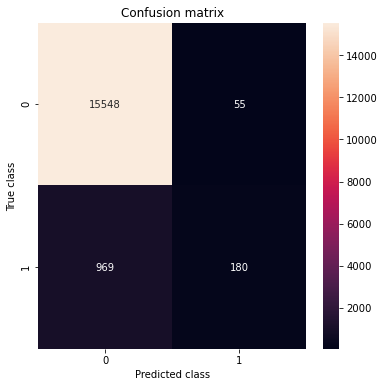

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     15603
           1       0.77      0.16      0.26      1149

    accuracy                           0.94     16752
   macro avg       0.85      0.58      0.61     16752
weighted avg       0.93      0.94      0.92     16752



In [34]:
mostrar_resultados(y_test, y_pred_rfc0)

In [35]:
# EXERCISE 2: RANDOM FOREST TO PREDICT HIGH RISK

result.groupby(['RIESGO_ALTO']).size()

RIESGO_ALTO
0    34040
1    21798
dtype: int64

In [34]:
#split dataset in features and target variable
feature_cols =  num_columns+ord_columns+cat_columns2
X = result[feature_cols] # Features
y = result['RIESGO_ALTO'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42) # 70% training and 30% test
y_test.value_counts()

0    10212
1     6540
Name: RIESGO_ALTO, dtype: int64

In [40]:
rfc=RandomForestClassifier()
grid_values = {'n_estimators': [20,50,100,150],
               'max_features': ['sqrt','auto',1.0],
               'max_depth' : [8,15,25,30]
              }
grid_search_rfc = GridSearchCV(rfc, param_grid = grid_values, scoring = 'recall')
grid_search_rfc.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 15, 25, 30],
                         'max_features': ['sqrt', 'auto', 1.0],
                         'n_estimators': [20, 50, 100, 150]},
             scoring='recall')

In [41]:
grid_search_rfc.best_params_

{'max_depth': 30, 'max_features': 1.0, 'n_estimators': 150}

In [35]:
rfc1=RandomForestClassifier(
    max_depth= 30, 
    max_features= 1.0, 
    n_estimators= 150
    )
rfc1.fit(X_train,y_train)
y_pred_rfc1 = rfc1.predict(X_test)
y_prob_rfc1 = rfc1.predict_proba(X_test)

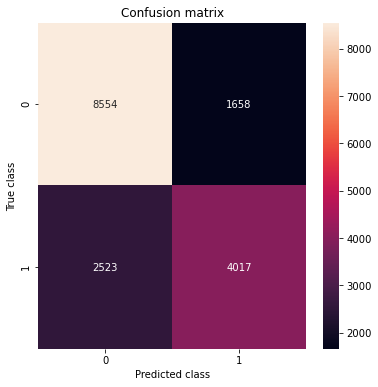

              precision    recall  f1-score   support

           0       0.77      0.84      0.80     10212
           1       0.71      0.61      0.66      6540

    accuracy                           0.75     16752
   macro avg       0.74      0.73      0.73     16752
weighted avg       0.75      0.75      0.75     16752



In [36]:
mostrar_resultados(y_test, y_pred_rfc1)

In [37]:
# EXERCISE 3: SET A DIFFERENT THRESHOLD TO INCREASE RECALL

y_pred_prob_rfc1 = (rfc1.predict_proba(X_test)[:,1] >= 0.38).astype(bool)

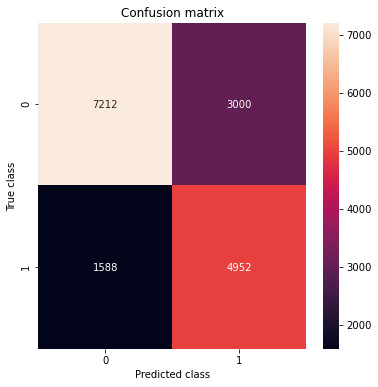

              precision    recall  f1-score   support

           0       0.82      0.71      0.76     10212
           1       0.62      0.76      0.68      6540

    accuracy                           0.73     16752
   macro avg       0.72      0.73      0.72     16752
weighted avg       0.74      0.73      0.73     16752



In [38]:
mostrar_resultados(y_test, y_pred_prob_rfc1)

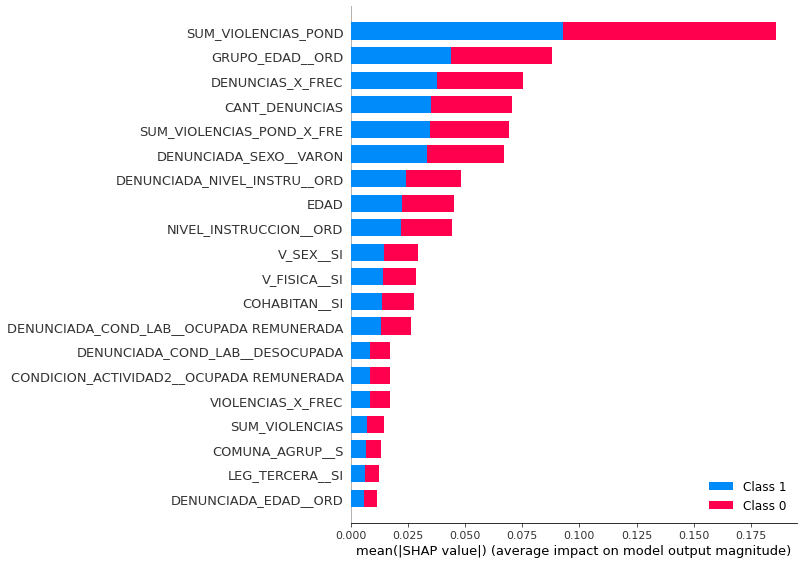

In [39]:
explainer = shap.TreeExplainer(rfc1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

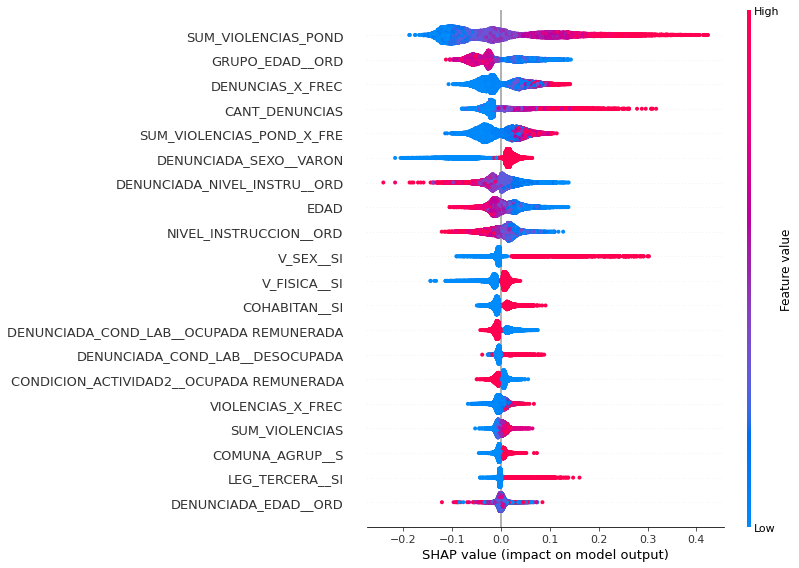

In [40]:
explainer = shap.TreeExplainer(rfc1)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

In [41]:
# REMOVING VARIABLES THAT ARE VERY SIMILAR AND HIGHLY CORRELATED
num_columns = [
               'EDAD',
               #'SUM_VIOLENCIAS',
               'CANT_DENUNCIAS',
               #'VIOLENCIAS_X_FREC',
               #'DENUNCIAS_X_FREC',
               #'SUM_VIOLENCIAS_POND',
               'SUM_VIOLENCIAS_POND_X_FRE'
               ] 
ord_columns = [
    #'GRUPO_EDAD__ORD',
    'NIVEL_INSTRUCCION__ORD',
    'FRECUENCIA_EPISODIOS__ORD',
    'DENUNCIADA_EDAD__ORD',
    'DENUNCIADA_NIVEL_INSTRU__ORD'
]


In [42]:
feature_cols =  num_columns+ord_columns+cat_columns2
X = result[feature_cols] # Features
y = result['RIESGO_ALTO'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42) # 70% training and 30% test
y_test.value_counts()

0    10212
1     6540
Name: RIESGO_ALTO, dtype: int64

In [43]:
# EXERCISE 4: TRAINING THE FINAL MODEL
rfc2=RandomForestClassifier(
    max_depth= 30, 
    max_features= 1.0, 
    n_estimators= 150
    )
rfc2.fit(X_train,y_train)
y_pred_rfc2 = rfc2.predict(X_test)
y_prob_rfc2 = rfc2.predict_proba(X_test)

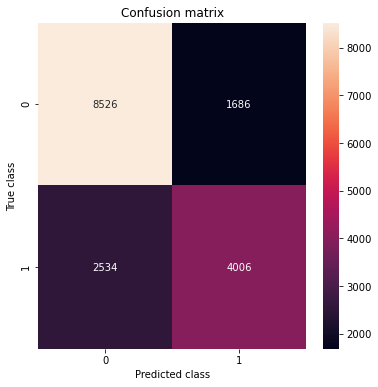

              precision    recall  f1-score   support

           0       0.77      0.83      0.80     10212
           1       0.70      0.61      0.66      6540

    accuracy                           0.75     16752
   macro avg       0.74      0.72      0.73     16752
weighted avg       0.74      0.75      0.74     16752



In [44]:
mostrar_resultados(y_test, y_pred_rfc2)

In [45]:
y_pred_prob_rfc2 = (rfc2.predict_proba(X_test)[:,1] >= 0.35).astype(bool)

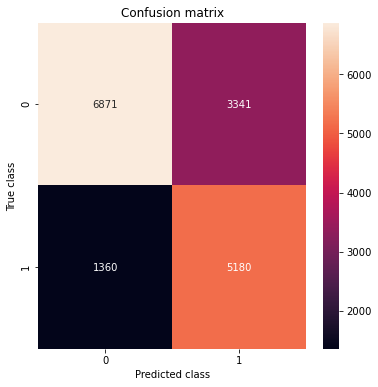

              precision    recall  f1-score   support

           0       0.83      0.67      0.75     10212
           1       0.61      0.79      0.69      6540

    accuracy                           0.72     16752
   macro avg       0.72      0.73      0.72     16752
weighted avg       0.75      0.72      0.72     16752



In [46]:
mostrar_resultados(y_test, y_pred_prob_rfc2)

In [47]:
importances = rfc2.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

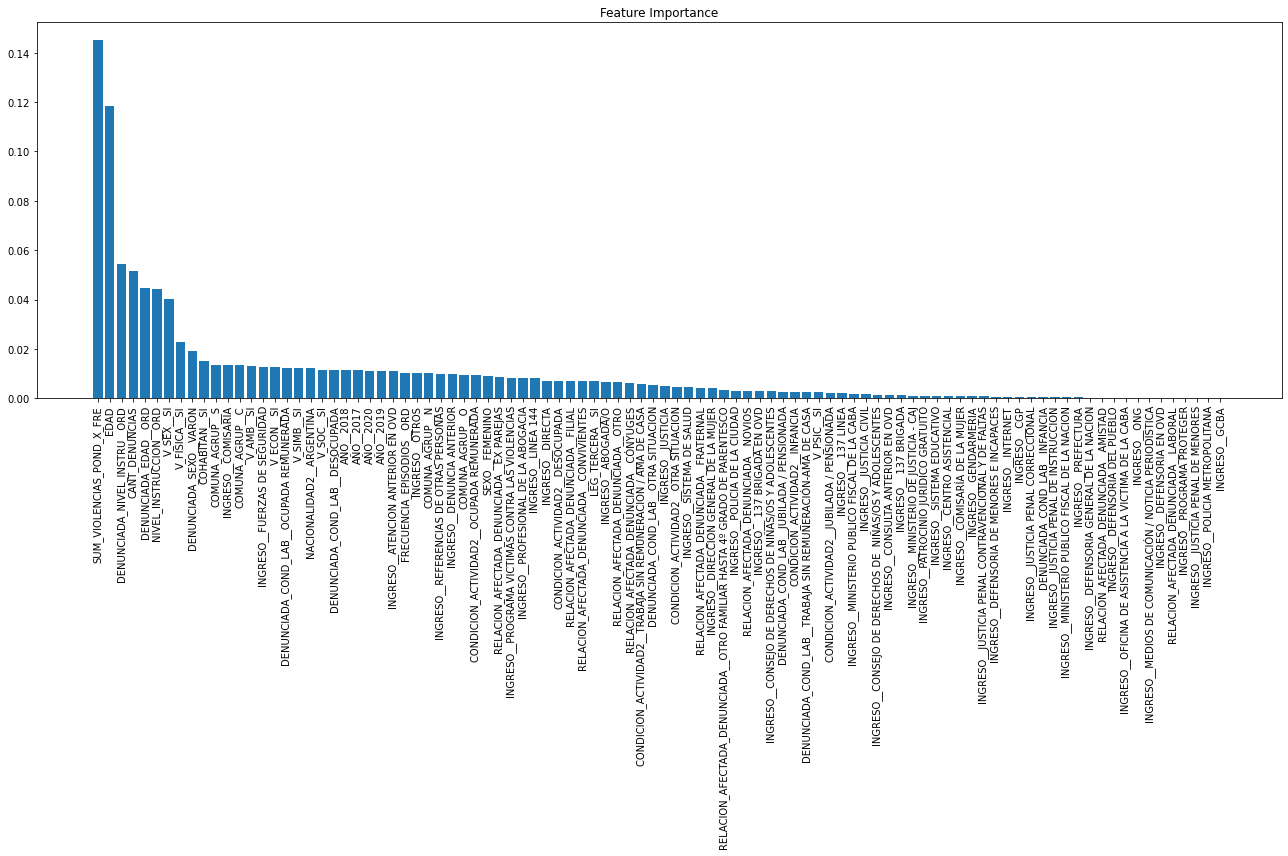

In [48]:
plt.figure(figsize=(18,12))
plt.title('Feature Importance')
plt.bar(range(X_test.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_test.shape[1]), X_test.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

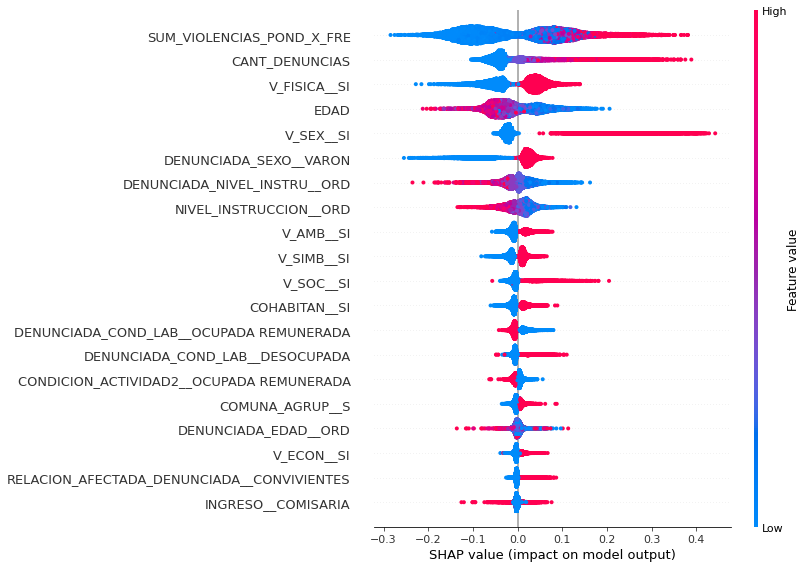

In [49]:
explainer = shap.TreeExplainer(rfc2)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

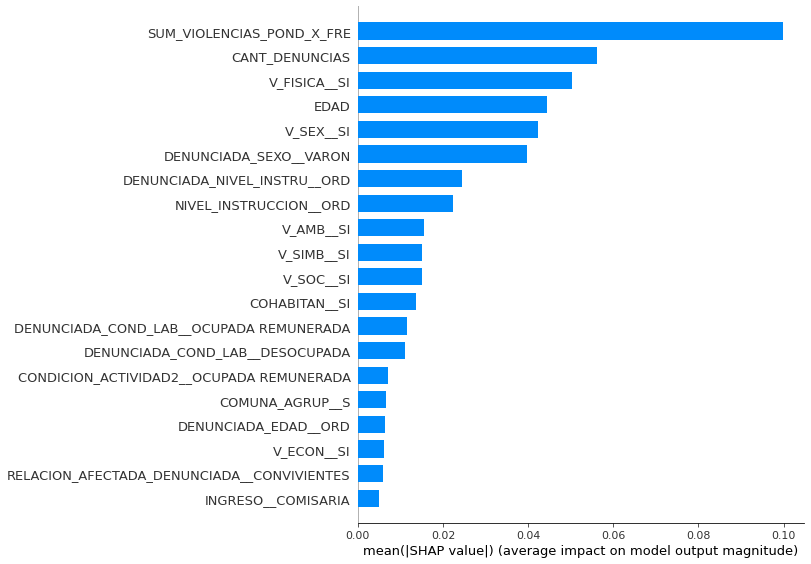

In [50]:
explainer = shap.TreeExplainer(rfc2)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test, plot_type='bar')

In [51]:
#Regresion logistica
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rl = LogisticRegression()
rl.fit(X_train_scaled, y_train)
# predict probabilities
y_prob_lr = rl.predict_proba(X_test_scaled)
y_pred_lr = rl.predict(X_test_scaled)

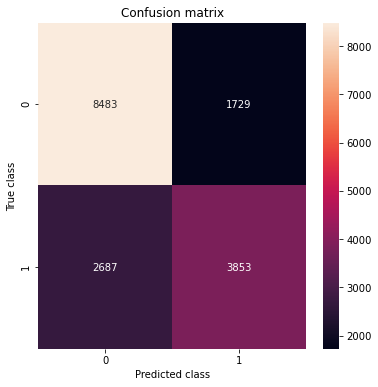

              precision    recall  f1-score   support

           0       0.76      0.83      0.79     10212
           1       0.69      0.59      0.64      6540

    accuracy                           0.74     16752
   macro avg       0.72      0.71      0.71     16752
weighted avg       0.73      0.74      0.73     16752



In [52]:
mostrar_resultados(y_test, y_pred_lr)

In [53]:
y_pred_prob_lr = (rl.predict_proba(X_test_scaled)[:,1] >= 0.35).astype(bool)

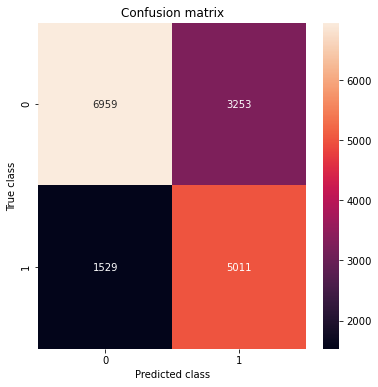

              precision    recall  f1-score   support

           0       0.82      0.68      0.74     10212
           1       0.61      0.77      0.68      6540

    accuracy                           0.71     16752
   macro avg       0.71      0.72      0.71     16752
weighted avg       0.74      0.71      0.72     16752



In [54]:
mostrar_resultados(y_test, y_pred_prob_lr)

In [55]:
gbc = GradientBoostingClassifier()
parameters = {
    #loss":["deviance"],
    "learning_rate": [0.065, 0.07, 0.075],
    #"min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": [1, 15, 30],
    "max_depth":[12,15,18],
    #"max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse",  "squared_error"],
    #"subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[300,320,350]
    }
grid_search_gbc = GridSearchCV(gbc, param_grid = parameters, scoring = 'recall')
grid_search_gbc.fit(X_train_scaled, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.065, 0.07, 0.075],
                         'max_depth': [12, 15, 18],
                         'min_samples_leaf': [1, 15, 30],
                         'n_estimators': [300, 320, 350]},
             scoring='recall')

In [56]:
grid_search_gbc.best_params_

{'learning_rate': 0.07,
 'max_depth': 12,
 'min_samples_leaf': 1,
 'n_estimators': 300}

In [57]:
gbc1=GradientBoostingClassifier(criterion= 'friedman_mse',
                                learning_rate= 0.075,
                                max_depth= 12,
                                max_features= 'sqrt',
                                n_estimators= 350)
gbc1.fit(X_train_scaled,y_train)
y_pred_gbc=gbc1.predict(X_test_scaled)
y_prob_gbc=gbc1.predict_proba(X_test_scaled)

In [58]:
y_pred_prob_gbc = (gbc1.predict_proba(X_test_scaled)[:,1] >= 0.35).astype(bool)

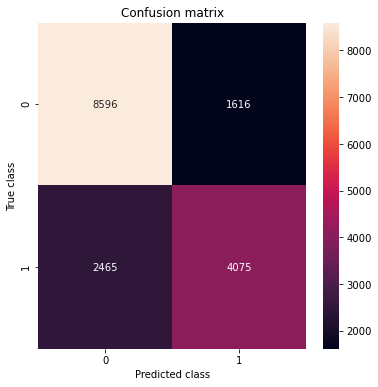

              precision    recall  f1-score   support

           0       0.78      0.84      0.81     10212
           1       0.72      0.62      0.67      6540

    accuracy                           0.76     16752
   macro avg       0.75      0.73      0.74     16752
weighted avg       0.75      0.76      0.75     16752



In [59]:
mostrar_resultados(y_test, y_pred_gbc)

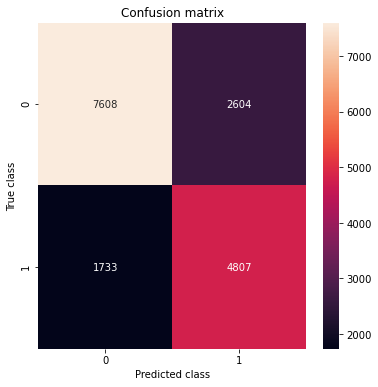

              precision    recall  f1-score   support

           0       0.81      0.75      0.78     10212
           1       0.65      0.74      0.69      6540

    accuracy                           0.74     16752
   macro avg       0.73      0.74      0.73     16752
weighted avg       0.75      0.74      0.74     16752



In [60]:
mostrar_resultados(y_test, y_pred_prob_gbc)

In [61]:
nnet = MLPClassifier(
    hidden_layer_sizes=(150,100,50), 
    max_iter=300,
    activation = 'relu',
    solver='adam',
    random_state=1)
nnet.fit(X_train_scaled, y_train)
y_pred_nnet = nnet.predict(X_test_scaled)
y_prob_nnet= nnet.predict_proba(X_test_scaled)

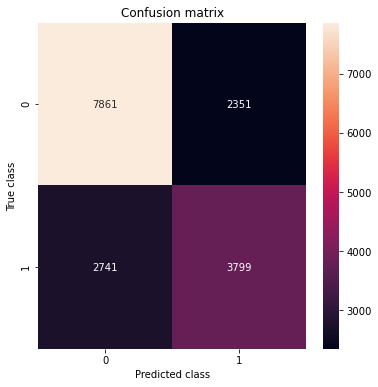

              precision    recall  f1-score   support

           0       0.74      0.77      0.76     10212
           1       0.62      0.58      0.60      6540

    accuracy                           0.70     16752
   macro avg       0.68      0.68      0.68     16752
weighted avg       0.69      0.70      0.69     16752



In [62]:
mostrar_resultados(y_test, y_pred_nnet)

In [63]:
y_pred_prob_nnet = (nnet.predict_proba(X_test_scaled)[:,1] >= 0.15).astype(bool)

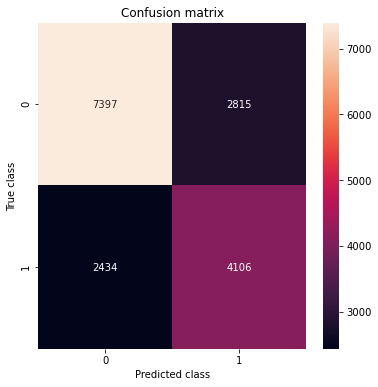

              precision    recall  f1-score   support

           0       0.75      0.72      0.74     10212
           1       0.59      0.63      0.61      6540

    accuracy                           0.69     16752
   macro avg       0.67      0.68      0.67     16752
weighted avg       0.69      0.69      0.69     16752



In [64]:
mostrar_resultados(y_test, y_pred_prob_nnet)

Azar: ROC AUC=0.500
Random Forest Classsifier: ROC AUC=0.815
Gradient Boosting Classsifier: ROC AUC=0.820
Logistic Regression: ROC AUC=0.801
Neural Network: ROC AUC=0.746


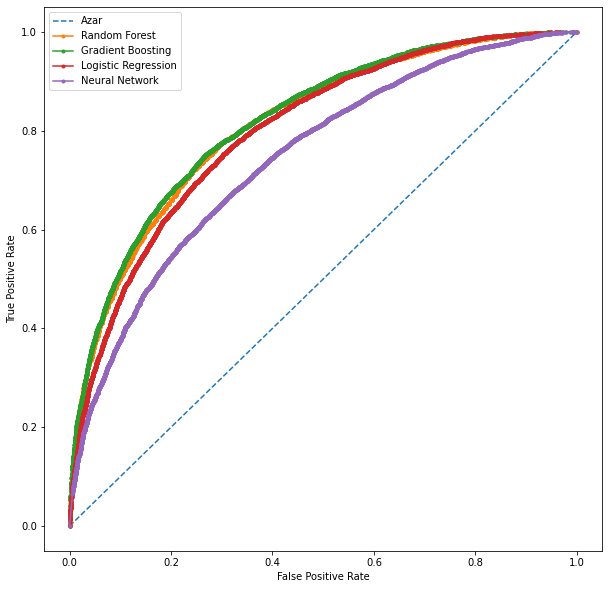

In [65]:
ns_probs = [0 for _ in range(len(y_test))]
# keep probabilities for the positive outcome only
rfc_probs = y_prob_rfc2[:, 1]
gbc_probs=y_prob_gbc[:, 1]
lr_probs=y_prob_lr[:, 1]
net_probs=y_prob_nnet[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
rfc_auc = roc_auc_score(y_test, rfc_probs)
gbc_auc = roc_auc_score(y_test, gbc_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
net_auc = roc_auc_score(y_test, net_probs)

# summarize scores
print('Azar: ROC AUC=%.3f' % (ns_auc))
print('Random Forest Classsifier: ROC AUC=%.3f' % (rfc_auc))
print('Gradient Boosting Classsifier: ROC AUC=%.3f' % (gbc_auc))
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc))
print('Neural Network: ROC AUC=%.3f' % (net_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rfc_fpr, rfc_tpr, _ = roc_curve(y_test, rfc_probs)
gbc_fpr, gbc_tpr, _ = roc_curve(y_test, gbc_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
net_fpr, net_tpr, _ = roc_curve(y_test, net_probs)


# plot the roc curve for the model
plt.figure(figsize=(10,10))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Azar')
plt.plot(rfc_fpr, rfc_tpr, marker='.', label='Random Forest')
plt.plot(gbc_fpr, gbc_tpr, marker='.', label='Gradient Boosting')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
plt.plot(net_fpr, net_tpr, marker='.', label='Neural Network')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Random Forest: f1=0.655 auc=0.748
Gradient Boosting: f1=0.581 auc=0.754
Logistic Regression: f1=0.030 auc=0.717
Neural Network: f1=0.618 auc=0.661


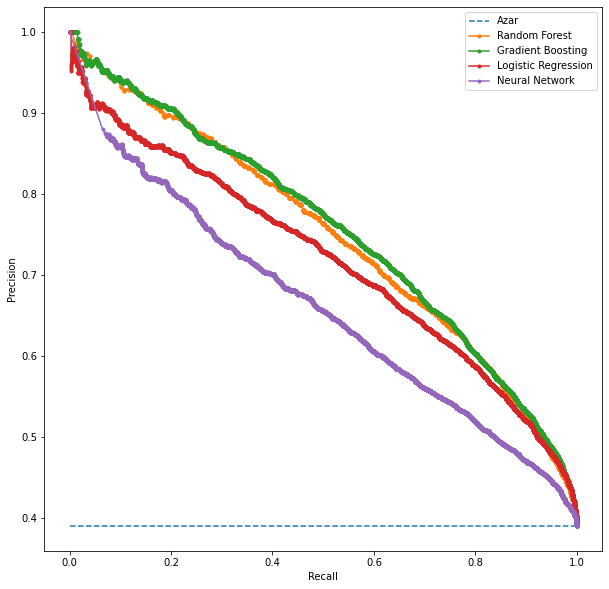

In [66]:
# precision-recall curve and f1
rfc_probs = y_prob_rfc2[:, 1]
rfc_yhat = rfc2.predict(X_test)
#rfc_yhat = (rfc2.predict_proba(X_test)[:,1] >= 0.5).astype(bool)

gbc_probs=y_prob_gbc[:, 1]
gbc_yhat = gbc1.predict(X_test)
#gbc_yhat = (gbc1.predict_proba(X_test)[:,1] >= 0.5).astype(bool)

lr_probs=y_prob_lr[:, 1]
lr_yhat = rl.predict(X_test)

net_probs=y_prob_nnet[:, 1]
net_yhat = nnet.predict(X_test)

rfc_precision, rfc_recall, _ = precision_recall_curve(y_test, rfc_probs)
rfc_f1, rfc_auc = f1_score(y_test, rfc_yhat), auc(rfc_recall, rfc_precision)
gbc_precision, gbc_recall, _ = precision_recall_curve(y_test, gbc_probs)
gbc_f1, gbc_auc = f1_score(y_test, gbc_yhat), auc(gbc_recall, gbc_precision)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, lr_yhat), auc(lr_recall, lr_precision)
net_precision, net_recall, _ = precision_recall_curve(y_test, net_probs)
net_f1, net_auc = f1_score(y_test, net_yhat), auc(net_recall, net_precision)
# summarize scores
print('Random Forest: f1=%.3f auc=%.3f' % (rfc_f1, rfc_auc))
print('Gradient Boosting: f1=%.3f auc=%.3f' % (gbc_f1, gbc_auc))
print('Logistic Regression: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
print('Neural Network: f1=%.3f auc=%.3f' % (net_f1, net_auc))

# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.figure(figsize=(10,10))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Azar')
plt.plot(rfc_recall, rfc_precision, marker='.', label='Random Forest')
plt.plot(gbc_recall, gbc_precision, marker='.', label='Gradient Boosting')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression')
plt.plot(net_recall, net_precision, marker='.', label='Neural Network')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()